In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Utilities import Tools
from mppi.Datasets import PostProcessing as PP
from mppi.Utilities import Constants as Const
import matplotlib.pyplot as plt
import numpy as np
import os, yaml
#import pybinding as pb

In [3]:
dry_run = False
rsync_str = "rsync -rLptgoDzv --exclude={'*_fragment_*','*_fragments_*','*wfc*','*.dat'} "
if dry_run: rsync_str += '--dry-run '
ssh_str = '-e ssh ismhpc:/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/GERMANENE/GW_HF_analysis/ '
dest_path = 'GW_HF_analysis'
dest_path = os.path.abspath(dest_path)
dest_path = "'%s'"%dest_path
command = rsync_str+ssh_str+dest_path
print(command)

rsync -rLptgoDzv --exclude={'*_fragment_*','*_fragments_*','*wfc*','*.dat'} -e ssh ismhpc:/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/GERMANENE/GW_HF_analysis/ '/m100_work/IscrC_XEXIN/Germanene/GW_HF_analysis'


In [3]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16
cpus_per_task=2
omp_num_threads=2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='fastnodes',
                memory='124000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.YamboCalculator(rr,activate_BeeOND=True) #,clean_restart=False,skip=False)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 16,
 'cpus_per_task': 2,
 'omp_num_threads': 2,
 'gpus_per_node': None,
 'memory': '124000',
 'time': None,
 'partition': 'fastnodes',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True}

In [3]:
# RunRules for m100
nodes = 8 # 32
ntasks_per_node = 4
cpus_per_task=32
omp_num_threads=8
gpus_per_node=4
pe=8

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='m100_usr_prod',
                account='IscrC_AlNWS2',#,qos='m100_qos_bprod',
                memory='230GB',time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gpus_per_node=gpus_per_node,pe=pe,
                map_by='socket',rank_by='core')
code = C.YamboCalculator(rr)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 8,
 'ntasks_per_node': 4,
 'cpus_per_task': 32,
 'omp_num_threads': 8,
 'gpus_per_node': 4,
 'memory': '230GB',
 'time': '23:59:00',
 'partition': 'm100_usr_prod',
 'account': 'IscrC_AlNWS2',
 'qos': None,
 'map_by': 'socket',
 'pe': 8,
 'rank_by': 'core',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True}

# GW convergence analysis of the Germanene

We compute the GW corrections of the DFT band structure of the Germanene. 

We discuss the convergene procedure using various approximations of the self-energy.

We have performed various preliminary tests in particular:

__Parallelization strategy__

We set the SE_ROLEs as 'b.qp.q' and we observe that (with 16 mpi)
* for HF analysis the highest performance are achieved with '16.1.1'
* 

__Random integration method (RIM) and Coulomb potential cutoff__

.........

## Hartree-Fock convergence analysis 

At the Hartree-Fock (HF) level the self energy is limited to the exchange part $\Sigma_x$ written in term of the
bare Coulomb potential.

The diagonal matrix elements of $\Sigma_x$ on the KS states are written as
$$
\langle nk|\Sigma_x|nk \rangle = -\sum_{n'}\int_{BZ}dq\sum_G \frac{4\pi}{|q+G|^2}
|\rho_{nn'}(k,q,G)|^2f_{n',k-q}
$$
The sum over $n'$ il limited to the full bands due the $f_{n'}$ factor and so the self energy in this
approximation scheme depends on the $k$-points sampling in the BZ (q sum) and on the cutoff of the plane wave
expansion of the KS states.

We study the converge of the direct gap at the $K$ point in function of the number of plane wave of the exchange (EXXRLvcs variable in Yambo).
The highest value of this variable is given by the cutoff of the density matrix in QuantumESPRESSO, that in turn is
4 times the cutoff on the KS wave functions ($90*4=360$ Ry in the present analysis).

We also study the convergence of the gap in function of the $k$-points sampling of the BZ.

In [20]:
#kvalues = [12,18,24,30,36,42,48,54,60,66,78]
kvalues = [81]

test_set = {}
for k in kvalues:
    #source_dir = 'DFT_analysis/kpoints_%s-nbnds_40.save'%k
    source_dir = 'DFT_analysis/kpoints_%s-nbnds_700.save'%k
    run_dir = 'GW_HF_analysis/kpoints_%s-nbnds_700'%k
    dft_data = P.PwParser(os.path.join(source_dir,'data-file-schema.xml'),verbose=False)
    test_set[k] = {'source_dir' : source_dir,
                   'run_dir' :  run_dir,
                    'K_index' : len(dft_data.kpoints)}
test_set

{81: {'source_dir': 'DFT_analysis/kpoints_81-nbnds_700.save',
  'run_dir': 'GW_HF_analysis/kpoints_81-nbnds_700',
  'K_index': 588}}

In [21]:
start_band,stop_band = 28,29 # bands range for the computation of the HF corrections

We build the input for HF analysis including the random integration method (RIM) for the small $q$ component of the Coulomb potential
and the cutoff of the Coulomb potential in the off plane direction. 

The z dimension of the simulation box is 
* $7.643*8 = 61.44$ au and we set the cutoff to 60 au
* $7.643*4 = 30.572$ au and we set the cutoff to 30 au

In [22]:
cut_z = 30 # 60 # au, slightly smaller than the cell, in agreement with the Yambo tutorial page
RandQpts = 1000000 # Number of random q-points in the BZ
RandGvec = 100 # use the RIM for the first 100 G-components of the coulomb potential 

### Analysis of the q-points sampling and of the and of the $G$-points expansion of the exchange term

First, we perform a convergence test on the EXXRLvsc parameter, than we study
the convergence of the $q$-point sampling

In [23]:
k_sel = 81
Tools.build_SAVE(test_set[k_sel]['source_dir'],test_set[k_sel]['run_dir'],command='mpirun -np 1 p2y')

Create folder GW_HF_analysis/kpoints_81-nbnds_700
Executing command: cd DFT_analysis/kpoints_81-nbnds_700.save; mpirun -np 1 p2y
Create a symlink of /m100_work/IscrC_XEXIN/Germanene/DFT_analysis/kpoints_81-nbnds_700.save/SAVE in GW_HF_analysis/kpoints_81-nbnds_700
Executing command: cd GW_HF_analysis/kpoints_81-nbnds_700;OMP_NUM_THREADS=1 mpirun -np 1 yambo


In [24]:
             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
             11555 fastnodes run_InAs filippon PD       0:00      1 (Dependency)
             11562 fastnodes run_InAs filippon PD       0:00      1 (Dependency)
             11567 slownodes orca-geo giuseppe PD       0:00      1 (Dependency)
             11520 fastnodes run_InGa filippon  R   13:11:29      1 wnode09
             11534 fastnodes run_InAs filippon  R   13:11:29      1 wnode10
             11561 slownodes run_InN. filippon  R    1:52:26      2 wnode[01-02]
             11566 slownodes orca-geo giuseppe  R    3:37:49      1 wnode04
[dalessandro@frontend ~]$ 
[dalessandro@frontend ~]$ 
[dalessandro@frontend ~]$ 

EXXRLvcs = [7000,9000,11000,15000] # RL

study = D.Dataset(run_dir=test_set[k_sel]['run_dir'],num_tasks=4,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput(args='mpirun -np 1 yambo -r -x -V all',folder=test_set[k_sel]['run_dir'])
inp.set_extendOut()
K_index = test_set[k_sel]['K_index']
inp.set_kRange(K_index,K_index)
inp.set_bandRange(start_band,stop_band)
inp['variables']['RandQpts'] = [RandQpts,'']
inp['variables']['RandGvec'] = [RandGvec,'']
inp['variables']['CUTGeo'] = 'box z'
inp['variables']['CUTBox'] = [[0.,0.,cut_z],'au']
inp['variables']['SE_CPU'] = '1.1.%s'%ntasks
inp['variables']['SE_ROLEs'] = 'q.qp.b'
#inp['variables']['SE_Threads'] = [4,'']

for ex in EXXRLvcs:
    idd = {'kpoints':k_sel,'exxrlvcs':ex,'cutbox':cut_z,'randQ':RandQpts,'randG':RandGvec}#,'nodes':nodes}
    #inp['variables']['EXXRLvcs'] = [ex,'Ry']
    inp['variables']['EXXRLvcs'] = [ex,'RL']
    study.append_run(id=idd,input=inp,runner=code)

Initialize a Dataset with 4 parallel tasks


In [25]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'GW_HF_analysis/kpoints_81-nbnds_700',
 'num_tasks': 4,
 'verbose': True,
 'input': {'args': 'mpirun -np 1 yambo -r -x -V all',
  'folder': 'GW_HF_analysis/kpoints_81-nbnds_700',
  'filename': 'yambo.in',
  'arguments': ['rim_cut', 'HF_and_locXC', 'ExtendOut'],
  'variables': {'StdoHash': [40.0, ''],
   'Nelectro': [28.0, ''],
   'ElecTemp': [0.0, 'eV'],
   'BoseTemp': [-1.0, 'eV'],
   'OccTresh': [1e-05, ''],
   'NLogCPUs': [0.0, ''],
   'MEM_tresh': [1961257.0, 'Kb'],
   'FFTGvecs': [17211.0, 'RL'],
   'SE_Threads': [0.0, ''],
   'RandQpts': [1000000, ''],
   'RandGvec': [100, ''],
   'IDEm1Ref': [0.0, ''],
   'CUTRadius': [0.0, ''],
   'CUTCylLen': [0.0, ''],
   'CUTwsGvec': [0.7, ''],
   'EXXRLvcs': [7000, 'RL'],
   'VXCRLvcs': [110823.0, 'RL'],
   'DBsIOoff': 'none',
   'DBsFRAGpm': 'none',
   'PAR_def_mode': 'balanced',
   'CUTGeo': 'box z',
   'Em1Anys': [[0.0, 0.0, 0.0], ''],
   'CUTBox': [[0.0, 0.0, 30], 'au'],
   'QPkrange': [[588, 588, 28, 29

In [ ]:
results = study.run()

Run the selection [0, 1, 2, 3] with the parallel task_groups [[0, 1, 2, 3]] 

Run the task [0, 1, 2, 3] 
run command: mpirun -np 16 --map-by socket:PE=8 --rank-by core yambo -F cutbox_30-exxrlvcs_7000-kpoints_81-randG_100-randQ_1000000.in -J cutbox_30-exxrlvcs_7000-kpoints_81-randG_100-randQ_1000000 -C cutbox_30-exxrlvcs_7000-kpoints_81-randG_100-randQ_1000000
slurm submit:  cd GW_HF_analysis/kpoints_81-nbnds_700 ; sbatch job_cutbox_30-exxrlvcs_7000-kpoints_81-randG_100-randQ_1000000.sh
computation cutbox_30-exxrlvcs_7000-kpoints_81-randG_100-randQ_1000000 is running...
run command: mpirun -np 16 --map-by socket:PE=8 --rank-by core yambo -F cutbox_30-exxrlvcs_9000-kpoints_81-randG_100-randQ_1000000.in -J cutbox_30-exxrlvcs_9000-kpoints_81-randG_100-randQ_1000000 -C cutbox_30-exxrlvcs_9000-kpoints_81-randG_100-randQ_1000000
slurm submit:  cd GW_HF_analysis/kpoints_81-nbnds_700 ; sbatch job_cutbox_30-exxrlvcs_9000-kpoints_81-randG_100-randQ_1000000.sh
computation cutbox_30-exxrlvcs_9000-

In [15]:
gap = [results[ind].data.get_gap(k_full=test_set[k_sel]['K_index'],band_full=start_band,verbose=False) for ind in range(len(EXXRLvcs))]
gap

[0.40980800000000006, 0.40981500000000004, 0.40981700000000004, 0.409817]

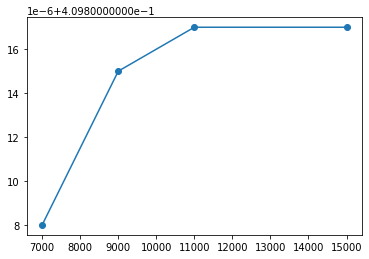

In [16]:
plt.plot(EXXRLvcs,gap)
plt.scatter(EXXRLvcs,gap)

We choose EXXRRLvcs = 60 Ry as converged value and analyze the convergence of the $q$-points sampling

In [9]:
EXXRLvcs_conv = 11000 # RL

Old results with the analysis of the $k$-points sampling:

In [10]:
study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in test_set:
    Tools.build_SAVE(test_set[k]['source_dir'],test_set[k]['run_dir'],command='p2y')
    inp = I.YamboInput(args='yambo -r -x -V all',folder=test_set[k]['run_dir'])
    inp.set_extendOut()
    K_index = test_set[k]['K_index']
    inp.set_kRange(K_index,K_index)
    inp.set_bandRange(start_band,stop_band)
    inp['variables']['EXXRLvcs'] = [EXXRLvcs_conv,'Ry']
    inp['variables']['RandQpts'] = [RandQpts,'']
    inp['variables']['RandGvec'] = [RandGvec,'']
    inp['variables']['CUTGeo'] = 'box z'
    inp['variables']['CUTBox'] = [[0.,0.,cut_z],'au']
    inp['variables']['SE_CPU'] = '%s.1.1'%mpi
    inp['variables']['SE_ROLEs'] = 'b.qp.q'
    
    idd = {'kpoints':k,'exxrlvcs':EXXRLvcs_conv,'cutbox':cut_z,'randQ':RandQpts,'randG':RandGvec}
    study.append_run(id=idd,input=inp,runner=code,run_dir=test_set[k]['run_dir'])

Initialize a Dataset with 1 parallel tasks
SAVE folder already present in GW_HF_analysis/kpoints_78. No operations performed.


In [11]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
delete job_out script: GW_HF_analysis/kpoints_78/job_cutbox_30-exxrlvcs_40-kpoints_78-randG_100-randQ_1000000.out
delete folder: GW_HF_analysis/kpoints_78/cutbox_30-exxrlvcs_40-kpoints_78-randG_100-randQ_1000000
run command: mpirun -np 16 yambo -F cutbox_30-exxrlvcs_40-kpoints_78-randG_100-randQ_1000000.in -J cutbox_30-exxrlvcs_40-kpoints_78-randG_100-randQ_1000000 -C cutbox_30-exxrlvcs_40-kpoints_78-randG_100-randQ_1000000
slurm submit:  cd GW_HF_analysis/kpoints_78 ; sbatch job_cutbox_30-exxrlvcs_40-kpoints_78-randG_100-randQ_1000000.sh
computation cutbox_30-exxrlvcs_40-kpoints_78-randG_100-randQ_1000000 is running...
computation cutbox_30-exxrlvcs_40-kpoints_78-randG_100-randQ_1000000 ended

        There are no o-* files.
        Maybe you have performed a ypp computation or wait_end_run and/or
        the dry_run option are active?
        Otherwise a possible error has occured during the computation
   

In [35]:
gap = []
for k in kvalues:
    r = study.fetch_results(id={'kpoints':k})[0]
    gap.append(r.data.get_gap(k_full=test_set[k]['K_index'],band_full=start_band,verbose=False))
gap

[1.162207,
 0.8491869999999999,
 0.7013119999999999,
 0.615127,
 0.559527,
 0.519778,
 0.490761,
 0.468854,
 0.45126199999999994,
 0.43705900000000003]

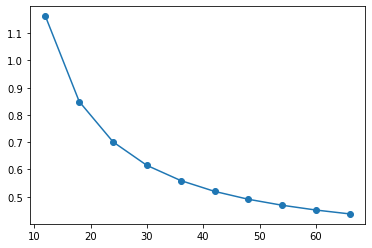

In [36]:
plt.plot(kvalues,gap)
plt.scatter(kvalues,gap)

In [37]:
from scipy.optimize import curve_fit

In [38]:
x = np.array(kvalues)
y = np.array(gap)

In [39]:
def exp(t,a,b,c):
    return a*np.exp(b*t)+c

In [40]:
p0 = [1,-0.1,0.5]
pars,pcov = curve_fit(exp,x,y,p0=p0)
pars

array([ 1.89850688, -0.08284485,  0.44739332])

In [46]:
x_ext = np.linspace(20,80)

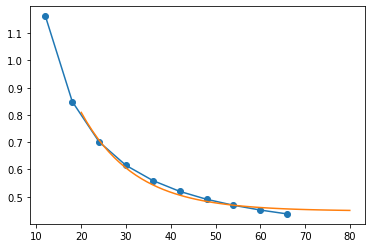

In [47]:
plt.plot(kvalues,gap)
plt.scatter(kvalues,gap)
plt.plot(x_ext,exp(x_ext,*pars))

## COHSEX convergence analysis 

We discuss different approximations for the self energy $\Sigma = G_0 W$. 
The evaluation of $W$ passes through:
$$
\chi = \chi_0 + \chi_0(v_H+f_{xc})\chi \\
W = v+v\chi v
$$

In the COHSEX one considers only the static contribution of the response $\chi(\omega=0)$ and we also limit our analysis to the Hartree kernel, so that $f_{xc}=0$ (RPA approximations).

In this case (without empties) G0 still depends only from the number of kpoints and from the EXXRLvcs parameter. Moreover we introduce also a non trivial W potential and two more parameters come into the play. These are the cut of in the plane wave expansion of the response function for the construction of W (NGsBlkXs) and the number of empty bands used to write the Lehmann representation of $\chi_0$ (BndsRnXs).

In [4]:
start_band,stop_band = 28,29 # bands range for the computation of the HF corrections

In [5]:
cut_z = 30 # 60 # au, slightly smaller than the cell, in agreement with the Yambo tutorial page
RandQpts = 1000000 # Number of random q-points in the BZ
RandGvec = 100 # use the RIM for the first 100 G-components of the coulomb potential 

In [4]:
kvalues = [60] #[81]

test_set = {}
for k in kvalues:
    source_dir = 'DFT_analysis/kpoints_%s-nbnds_700.save'%k
    run_dir = 'GW_HF_analysis/kpoints_%s-nbnds_700'%k
    #run_dir = 'GW_HF_analysis/kpoints_%s-nbnds_700_yambo-module'%k
    dft_data = P.PwParser(os.path.join(source_dir,'data-file-schema.xml'),verbose=False)
    test_set[k] = {'source_dir' : source_dir,
                   'run_dir' :  run_dir,
                    'K_index' : len(dft_data.kpoints)}
test_set

{60: {'source_dir': 'DFT_analysis/kpoints_60-nbnds_700.save',
  'run_dir': 'GW_HF_analysis/kpoints_60-nbnds_700',
  'K_index': 331}}

In [5]:
k_sel = 60 #81
Tools.build_SAVE(test_set[k_sel]['source_dir'],test_set[k_sel]['run_dir'],command='mpirun -np 1 p2y')
K_index = test_set[k_sel]['K_index']

SAVE folder already present in GW_HF_analysis/kpoints_60-nbnds_700. No operations performed.


In [10]:
#input for kpoints = 60, 2 nodes

ntasks_c = 8 #32
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

EXXRLvcs_conv = 11000 # RL
NGsBlkXs = [600] # RL G size of the response function
BndsRnXs  = [1,300] # Bands in the response function

inp = I.YamboInput(args='mpirun -np 1 yambo -r -k hartee -dyson n -gw0 c -V all',folder=test_set[k_sel]['run_dir'])
inp['variables']['RandQpts'] = [RandQpts,'']
inp['variables']['RandGvec'] = [RandGvec,'']
inp['variables']['CUTGeo'] = 'box z'
inp['variables']['CUTBox'] = [[0.,0.,cut_z],'au']
inp['variables']['EXXRLvcs'] = [EXXRLvcs_conv,'RL']

# Parallel roles
inp['variables']['SE_CPU'] = '1.1.8' #'4.2.16'
inp['variables']['SE_ROLEs'] = 'q.qp.b'
inp['variables']['X_and_IO_ROLEs'] = 'q.g.k.c.v'
inp['variables']['X_and_IO_CPU'] = '1.1.1.%s.%s'%(ntasks_c,ntasks_v)
inp['variables']['DIP_ROLEs'] = 'k.c.v'
inp['variables']['DIP_CPU'] = '1.%s.%s'%(ntasks_c,ntasks_v)

inp.set_kRange(K_index,K_index)
inp.set_bandRange(start_band,stop_band)
#inp

8 1


In [58]:
ntasks_c = 16 #32
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

EXXRLvcs_conv = 11000 # RL
NGsBlkXs = [600,800,1000,1200,1400,1600,1800,2000] # 1000 # RL G size of the response function
BndsRnXs  = [1,100] # Bands in the response function
GbndRnge = [1,100]  # Bands in the Sigma_c (used only if UseEbands is activated)

inp = I.YamboInput(args='mpirun -np 1 yambo -r -k hartee -dyson n -gw0 c -V all',folder=test_set[k_sel]['run_dir'])
inp['variables']['RandQpts'] = [RandQpts,'']
inp['variables']['RandGvec'] = [RandGvec,'']
inp['variables']['CUTGeo'] = 'box z'
inp['variables']['CUTBox'] = [[0.,0.,cut_z],'au']
inp['variables']['EXXRLvcs'] = [EXXRLvcs_conv,'RL']

# Parallel roles
#inp['variables']['SE_CPU'] = '1.1.%s'%ntasks
inp['variables']['SE_CPU'] = '8.2.16' #'4.2.16'
inp['variables']['SE_ROLEs'] = 'q.qp.b'
inp['variables']['X_and_IO_ROLEs'] = 'q.g.k.c.v'
inp['variables']['X_and_IO_CPU'] = '1.1.1.%s.%s'%(ntasks_c,ntasks_v)
inp['variables']['DIP_ROLEs'] = 'k.c.v'
inp['variables']['DIP_CPU'] = '1.%s.%s'%(ntasks_c,ntasks_v)

inp.set_kRange(K_index,K_index)
inp.set_bandRange(start_band,stop_band)
#inp

16 8


In [11]:
study = D.Dataset(run_dir=run_dir,num_tasks=4,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp['variables']['BndsRnXs'] = [BndsRnXs,'']
for ngs in NGsBlkXs:
    idd = 'chosex-ngsblkxs_%s-bndsrnxs_%s'%(ngs,BndsRnXs[1])
    inp['variables']['NGsBlkXs'] = [ngs,'RL']
    study.append_run(id=idd,input=inp,runner=code)

#idd = 'chosex-with_empties-ngsblkxs_%s-bndsrnxs_%s-gbndrnge_%s'%(NGsBlkXs,BndsRnXs[1],GbndRnge[1])
#inp['arguments'].append('UseEbands')
#inp['variables']['GbndRnge'] = [GbndRnge,'']
#study.append_run(id=idd,input=inp,runner=code)

Initialize a Dataset with 4 parallel tasks


In [12]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'GW_HF_analysis/kpoints_60-nbnds_700',
 'num_tasks': 4,
 'verbose': True,
 'input': {'args': 'mpirun -np 1 yambo -r -k hartee -dyson n -gw0 c -V all',
  'folder': 'GW_HF_analysis/kpoints_60-nbnds_700',
  'filename': 'yambo.in',
  'arguments': ['rim_cut', 'em1s', 'gw0', 'HF_and_locXC', 'cohsex'],
  'variables': {'StdoHash': [40.0, ''],
   'Nelectro': [28.0, ''],
   'ElecTemp': [0.0, 'eV'],
   'BoseTemp': [-1.0, 'eV'],
   'OccTresh': [1e-05, ''],
   'NLogCPUs': [0.0, ''],
   'MEM_tresh': [51200.0, 'Kb'],
   'FFTGvecs': [17211.0, 'RL'],
   'DIP_Threads': [0.0, ''],
   'X_and_IO_nCPU_LinAlg_INV': [-1.0, ''],
   'X_Threads': [0.0, ''],
   'SE_Threads': [0.0, ''],
   'RandQpts': [1000000, ''],
   'RandGvec': [100, ''],
   'IDEm1Ref': [0.0, ''],
   'CUTRadius': [0.0, ''],
   'CUTCylLen': [0.0, ''],
   'CUTwsGvec': [0.7, ''],
   'EXXRLvcs': [11000, 'RL'],
   'VXCRLvcs': [110823.0, 'RL'],
   'DipoleEtresh': [1e-05, 'eV'],
   'XfnQP_INTERP_NN': [1.0, ''],
   'Xfn

In [ ]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 8 --map-by socket:PE=8 --rank-by core yambo -F chosex-ngsblkxs_600-bndsrnxs_300.in -J chosex-ngsblkxs_600-bndsrnxs_300 -C chosex-ngsblkxs_600-bndsrnxs_300
slurm submit:  cd GW_HF_analysis/kpoints_60-nbnds_700 ; sbatch job_chosex-ngsblkxs_600-bndsrnxs_300.sh
computation chosex-ngsblkxs_600-bndsrnxs_300 is running...
Submitted batch job 5647878


In [62]:
gap = []
for ind in range(len(NGsBlkXs)):
    #r = study.fetch_results(id={'kpoints':k})[0]
    gap.append(results[ind].data.get_gap(k_full=test_set[k]['K_index'],band_full=start_band,verbose=False))
gap

[0.13907000000000003,
 0.13943099999999997,
 0.13968899999999995,
 0.13986500000000002,
 0.13993600000000006,
 0.1399840000000001,
 0.14002199999999998,
 0.14002800000000004]

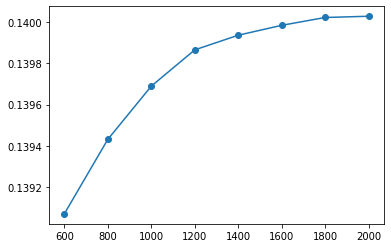

In [63]:
plt.plot(NGsBlkXs,gap)
plt.scatter(NGsBlkXs,gap)

We now perform a convergence analysis on the number of bands of the reponse function

In [42]:
ntasks_c = 16 #32
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

EXXRLvcs_conv = 11000 # RL
NGsBlkXs_conv = 2000  # RL G size of the response function
BndsRnXs  = [[1,100],[1,200],[1,300],[1,400],[1,500]] #[[1,100],[1,200],[1,300]] # Bands in the response function

inp = I.YamboInput(args='mpirun -np 1 yambo -r -k hartee -dyson n -gw0 c -V all',folder=test_set[k_sel]['run_dir'])
inp['variables']['RandQpts'] = [RandQpts,'']
inp['variables']['RandGvec'] = [RandGvec,'']
inp['variables']['CUTGeo'] = 'box z'
inp['variables']['CUTBox'] = [[0.,0.,cut_z],'au']
inp['variables']['EXXRLvcs'] = [EXXRLvcs_conv,'RL']

# Parallel roles
inp['variables']['SE_CPU'] = '4.2.16'  # '8.2.16' set for 64 nodes but works also for 32 with INCOMPLETE SE warning...
inp['variables']['SE_ROLEs'] = 'q.qp.b'
inp['variables']['X_and_IO_ROLEs'] = 'q.g.k.c.v'
inp['variables']['X_and_IO_CPU'] = '1.1.1.%s.%s'%(ntasks_c,ntasks_v)
inp['variables']['DIP_ROLEs'] = 'k.c.v'
inp['variables']['DIP_CPU'] = '1.%s.%s'%(ntasks_c,ntasks_v)

inp.set_kRange(K_index,K_index)
inp.set_bandRange(start_band,stop_band)

16 8


In [43]:
study = D.Dataset(run_dir=run_dir,num_tasks=4,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp['variables']['NGsBlkXs'] = [NGsBlkXs_conv,'RL']
for bnd in BndsRnXs:
    idd = 'chosex-ngsblkxs_%s-bndsrnxs_%s'%(NGsBlkXs_conv,bnd[1])
    inp['variables']['BndsRnXs'] = [bnd,'']
    study.append_run(id=idd,input=inp,runner=code)

Initialize a Dataset with 4 parallel tasks


In [44]:
#study.runs[0]

In [45]:
results = study.run()

Run the selection [0, 1, 2, 3, 4] with the parallel task_groups [[0, 1, 2, 3], [4]] 

Run the task [0, 1, 2, 3] 
Skip the run of Skip the run ofchosex-ngsblkxs_2000-bndsrnxs_100 
chosex-ngsblkxs_2000-bndsrnxs_200
Skip the run of chosex-ngsblkxs_2000-bndsrnxs_300
Skip the run of chosex-ngsblkxs_2000-bndsrnxs_400
Task [0, 1, 2, 3] ended 
 
Run the task [4] 
Skip the run of chosex-ngsblkxs_2000-bndsrnxs_500
Task [4] ended 
 


In [46]:
gap = []
for ind in range(len(BndsRnXs)):
    #r = study.fetch_results(id={'kpoints':k})[0]
    gap.append(results[ind].data.get_gap(k_full=test_set[k]['K_index'],band_full=start_band,verbose=False))
gap

[0.14002800000000004,
 0.1366989999999999,
 0.135621,
 0.13528799999999985,
 0.13511399999999996]

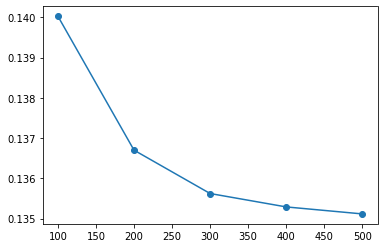

In [47]:
x = [b[1] for b in BndsRnXs]
plt.plot(x,gap)
plt.scatter(x,gap)

## Plasmon pole analysis 

In [5]:
start_band,stop_band = 28,29 # bands range for the computation of the HF corrections

In [6]:
cut_z = 30 # 60 # au, slightly smaller than the cell, in agreement with the Yambo tutorial page
RandQpts = 1000000 # Number of random q-points in the BZ
RandGvec = 100 # use the RIM for the first 100 G-components of the coulomb potential 

In [7]:
kvalues = [60]

test_set = {}
for k in kvalues:
    source_dir = 'DFT_analysis/kpoints_%s-nbnds_700.save'%k
    run_dir = 'GW_HF_analysis/kpoints_%s-nbnds_700'%k
    dft_data = P.PwParser(os.path.join(source_dir,'data-file-schema.xml'),verbose=False)
    test_set[k] = {'source_dir' : source_dir,
                   'run_dir' :  run_dir,
                    'K_index' : len(dft_data.kpoints)}
test_set

{60: {'source_dir': 'DFT_analysis/kpoints_60-nbnds_700.save',
  'run_dir': 'GW_HF_analysis/kpoints_60-nbnds_700',
  'K_index': 331}}

In [7]:
k_sel = 60
Tools.build_SAVE(test_set[k_sel]['source_dir'],test_set[k_sel]['run_dir'],command='mpirun -np 1 p2y')
K_index = test_set[k_sel]['K_index']

SAVE folder already present in GW_HF_analysis/kpoints_60-nbnds_700. No operations performed.


In [32]:
#input for kpoints = 60, 2 nodes on ismhpc

ntasks_c = 16 #32
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

EXXRLvcs_conv = 11000 # RL
NGsBlkXs_conv = 600 # RL G size of the response function
BndsRnXs_conv  = [1,300] # Bands in the response function
GbndRnge = [[1,300]]  # Bands in the Sigma_c

inp = I.YamboInput(args='mpirun -np 1 yambo -r -k hartee -dyson n -gw0 p -V all',folder=test_set[k_sel]['run_dir'])
inp['variables']['RandQpts'] = [RandQpts,'']
inp['variables']['RandGvec'] = [RandGvec,'']
inp['variables']['CUTGeo'] = 'box z'
inp['variables']['CUTBox'] = [[0.,0.,cut_z],'au']
inp['variables']['EXXRLvcs'] = [EXXRLvcs_conv,'RL']

# Parallel roles
inp['variables']['SE_CPU'] = '2.1.16'
inp['variables']['SE_ROLEs'] = 'q.qp.b'
inp['variables']['X_and_IO_ROLEs'] = 'q.g.k.c.v'
inp['variables']['X_and_IO_CPU'] = '1.1.1.%s.%s'%(ntasks_c,ntasks_v)
inp['variables']['DIP_ROLEs'] = 'k.c.v'
inp['variables']['DIP_CPU'] = '1.%s.%s'%(ntasks_c,ntasks_v)

inp.set_kRange(K_index,K_index)
inp.set_bandRange(start_band,stop_band)
#inp

16 2


In [9]:
#input for kpoints = 60, 8 nodes on m100

ntasks_c = 16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

EXXRLvcs_conv = 11000 # RL
NGsBlkXs_conv = 600 # RL G size of the response function
BndsRnXs_conv  = [1,300] # Bands in the response function
GbndRnge = [[1,300]]  # Bands in the Sigma_c

inp = I.YamboInput(args='mpirun -np 1 yambo -r -k hartee -dyson n -gw0 p -V all',folder=test_set[k_sel]['run_dir'])
inp['variables']['RandQpts'] = [RandQpts,'']
inp['variables']['RandGvec'] = [RandGvec,'']
inp['variables']['CUTGeo'] = 'box z'
inp['variables']['CUTBox'] = [[0.,0.,cut_z],'au']
inp['variables']['EXXRLvcs'] = [EXXRLvcs_conv,'RL']

# Parallel roles
inp['variables']['SE_CPU'] = '2.1.16'
inp['variables']['SE_ROLEs'] = 'q.qp.b'
inp['variables']['X_and_IO_ROLEs'] = 'q.g.k.c.v'
inp['variables']['X_and_IO_CPU'] = '1.1.1.%s.%s'%(ntasks_c,ntasks_v)
inp['variables']['DIP_ROLEs'] = 'k.c.v'
inp['variables']['DIP_CPU'] = '1.%s.%s'%(ntasks_c,ntasks_v)

inp.set_kRange(K_index,K_index)
inp.set_bandRange(start_band,stop_band)
#inp

16 2


In [9]:
study = D.Dataset(run_dir=run_dir,num_tasks=4,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp['variables']['NGsBlkXp'] = [NGsBlkXs_conv,'RL']
inp['variables']['BndsRnXp'] = [BndsRnXs_conv,'']
for bnd in GbndRnge:
    idd = 'ppa-ngsblkxs_%s-bndsrnxs_%s-gbndrnge_%s'%(NGsBlkXs_conv,BndsRnXs_conv[1],bnd[1])
    inp['variables']['GbndRnge'] = [GbndRnge,'']
    study.append_run(id=idd,input=inp,runner=code,jobname = [idd,'ndb_cutoff_rim_dipoles_hf'])

Initialize a Dataset with 4 parallel tasks


In [ ]:
study.runs[0]

In [12]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
Skip the run of ppa-ngsblkxs_600-bndsrnxs_300-gbndrnge_300
Task [0] ended 
 


In [15]:
gap = []
for ind in range(len(GbndRnge)):
    gap.append(results[ind].data.get_gap(k_full=test_set[k]['K_index'],band_full=start_band,verbose=False))
gap

[0.14194999999999997]

### Double grid analysis

We repeat the plasmon pole calculation using the double grid methods. We make usage of the 81x81x1
DFT energies as fine grids.

Once that the ndb.Double_Grid db haas been written in the SAVE folder we run again the ppa calculation.

In [10]:
study = D.Dataset(run_dir=run_dir,num_tasks=4,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp['variables']['NGsBlkXp'] = [NGsBlkXs_conv,'RL']
inp['variables']['BndsRnXp'] = [BndsRnXs_conv,'']
for bnd in GbndRnge:
    idd = 'ppa_dg-ngsblkxs_%s-bndsrnxs_%s-gbndrnge_%s'%(NGsBlkXs_conv,BndsRnXs_conv[1],bnd[1])
    inp['variables']['GbndRnge'] = [GbndRnge,'']
    study.append_run(id=idd,input=inp,runner=code,jobname = [idd,'ndb_cutoff_rim_dipoles_hf'])

Initialize a Dataset with 4 parallel tasks


In [ ]:
study.runs[0]

In [ ]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 32 --map-by socket:PE=8 --rank-by core yambo -F ppa_dg-ngsblkxs_600-bndsrnxs_300-gbndrnge_300.in -J "ppa_dg-ngsblkxs_600-bndsrnxs_300-gbndrnge_300,ndb_cutoff_rim_dipoles_hf" -C ppa_dg-ngsblkxs_600-bndsrnxs_300-gbndrnge_300
slurm submit:  cd GW_HF_analysis/kpoints_60-nbnds_700 ; sbatch job_ppa_dg-ngsblkxs_600-bndsrnxs_300-gbndrnge_300.sh
computation ppa_dg-ngsblkxs_600-bndsrnxs_300-gbndrnge_300 is running...
Submitted batch job 5731578


In [ ]:
gap = []
for ind in range(len(GbndRnge)):
    gap.append(results[ind].data.get_gap(k_full=test_set[k]['K_index'],band_full=start_band,verbose=False))
gap

A this level it is possible to perform a convergence test on the GbndRnge parameter. So we can add in the -J the path
where the ndb.pp is located and we can perform the run four various values of GbndRnge.

In [17]:
#ntasks_c = 8 # m100: 16 for 8 nodes and 8 for 2 nodes
ntasks_c = 16 # ismhpc: 16 for 2 nodes
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

EXXRLvcs_conv = 11000 # RL
NGsBlkXs_conv = 600 # RL G size of the response function
BndsRnXs_conv  = [1,300] # Bands in the response function

inp = I.YamboInput(args='mpirun -np 1 yambo -r -k hartee -dyson n -gw0 p -V all',folder=test_set[k_sel]['run_dir'])
inp['variables']['RandQpts'] = [RandQpts,'']
inp['variables']['RandGvec'] = [RandGvec,'']
inp['variables']['CUTGeo'] = 'box z'
inp['variables']['CUTBox'] = [[0.,0.,cut_z],'au']
inp['variables']['EXXRLvcs'] = [EXXRLvcs_conv,'RL']
inp['variables']['NGsBlkXp'] = [NGsBlkXs_conv,'RL']
inp['variables']['BndsRnXp'] = [BndsRnXs_conv,'']

# Parallel roles
#inp['variables']['SE_CPU'] = '2.1.16' # for 8 nodes on m100
#inp['variables']['SE_CPU'] = '1.1.8' # for 2 nodes on m100
inp['variables']['SE_CPU'] = '2.1.16' # for 2 nodes on ismhpc
inp['variables']['SE_ROLEs'] = 'q.qp.b'
inp['variables']['X_and_IO_ROLEs'] = 'q.g.k.c.v'
inp['variables']['X_and_IO_CPU'] = '1.1.1.%s.%s'%(ntasks_c,ntasks_v)
inp['variables']['DIP_ROLEs'] = 'k.c.v'
inp['variables']['DIP_CPU'] = '1.%s.%s'%(ntasks_c,ntasks_v)

inp.set_kRange(K_index,K_index)
inp.set_bandRange(start_band,stop_band)
#inp

16 2


In [23]:
GbndRnge = [[1,100],[1,300]] #,[1,500]]  # Bands in the Sigma_c

In [24]:
study = D.Dataset(run_dir=run_dir,num_tasks=4,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for bnd in GbndRnge:
    idd = 'ppa_dg-ngsblkxs_%s-bndsrnxs_%s-gbndrnge_%s'%(NGsBlkXs_conv,BndsRnXs_conv[1],bnd[1])
    inp['variables']['GbndRnge'] = [bnd,'']
    study.append_run(id=idd,input=inp,runner=code,jobname = [idd,'ndb_cutoff_rim_dipoles_hf','ndb_pp_dg_ngsblkxs_600-bndsrnxs_300','ndb_double_grid'])

Initialize a Dataset with 4 parallel tasks


In [25]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'GW_HF_analysis/kpoints_60-nbnds_700',
 'num_tasks': 4,
 'verbose': True,
 'input': {'args': 'mpirun -np 1 yambo -r -k hartee -dyson n -gw0 p -V all',
  'folder': 'GW_HF_analysis/kpoints_60-nbnds_700',
  'filename': 'yambo.in',
  'arguments': ['rim_cut', 'em1d', 'gw0', 'HF_and_locXC', 'ppa'],
  'variables': {'StdoHash': [40.0, ''],
   'Nelectro': [28.0, ''],
   'ElecTemp': [0.0, 'eV'],
   'BoseTemp': [-1.0, 'eV'],
   'OccTresh': [1e-05, ''],
   'NLogCPUs': [0.0, ''],
   'MEM_tresh': [51200.0, 'Kb'],
   'FFTGvecs': [17211.0, 'RL'],
   'X_and_IO_nCPU_LinAlg_INV': [-1.0, ''],
   'X_Threads': [0.0, ''],
   'DIP_Threads': [0.0, ''],
   'SE_Threads': [0.0, ''],
   'RandQpts': [1000000, ''],
   'RandGvec': [100, ''],
   'IDEm1Ref': [0.0, ''],
   'CUTRadius': [0.0, ''],
   'CUTCylLen': [0.0, ''],
   'CUTwsGvec': [0.7, ''],
   'EXXRLvcs': [11000, 'RL'],
   'VXCRLvcs': [110823.0, 'RL'],
   'XfnQP_INTERP_NN': [1.0, ''],
   'XfnQP_INTERP_shells': [20.0, ''],
   'Xf

In [26]:
results = study.run()

Run the selection [0, 1] with the parallel task_groups [[0, 1]] 

Run the task [0, 1] 
Skip the run of ppa_dg-ngsblkxs_600-bndsrnxs_300-gbndrnge_100
Skip the run of ppa_dg-ngsblkxs_600-bndsrnxs_300-gbndrnge_300
Task [0, 1] ended 
 


In [27]:
gap = []
for ind in range(len(GbndRnge)):
    gap.append(results[ind].data.get_gap(k_full=test_set[k]['K_index'],band_full=start_band,verbose=False))
gap

[0.142601, 0.141945]

### GW correction in the whole BZ

Once that we have computed the $\epsilon^{-1}$ we can evalute the GW corrections in all the $k$ points
of the actual grids and for a proper band index range around the valence-conduction states.

This computation is useful to determine the GW correction to the DFT band structure and moreover, is used
to compute the BSE optical spectrum. 

In [8]:
start_kp,stop_kp = 1,331
start_band,stop_band = 25,32 # bands range for the computation of the GW corrections

We need to compute the HF correction for all the $k$ points and band range

In [10]:
ntasks_c = 16 # ismhpc: 16 for 2 nodes
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

EXXRLvcs_conv = 11000 # RL

inp = I.YamboInput(args='mpirun -np 1 yambo -r -x -V all',folder=test_set[k_sel]['run_dir'])
inp['variables']['RandQpts'] = [RandQpts,'']
inp['variables']['RandGvec'] = [RandGvec,'']
inp['variables']['CUTGeo'] = 'box z'
inp['variables']['CUTBox'] = [[0.,0.,cut_z],'au']
inp['variables']['EXXRLvcs'] = [EXXRLvcs_conv,'RL']
inp['variables']['VXCRLvcs'] = [EXXRLvcs_conv,'RL']

# Parallel roles
inp['variables']['SE_CPU'] = '1.2.16' # for 8 nodes on m100
#inp['variables']['SE_CPU'] = '1.1.8' # for 2 nodes on m100
#inp['variables']['SE_CPU'] = '1.2.16' # for 2 nodes on ismhpc
inp['variables']['SE_ROLEs'] = 'q.qp.b'
inp['variables']['DIP_ROLEs'] = 'k.c.v'
inp['variables']['DIP_CPU'] = '1.%s.%s'%(ntasks_c,ntasks_v)

inp.set_kRange(start_kp,stop_kp)
inp.set_bandRange(start_band,stop_band)
#inp    

16 2


In [12]:
study = D.Dataset(run_dir=run_dir,num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

idd = 'hf-kp_%s_%s-bnd_%s_%s'%(start_kp,stop_kp,start_band,stop_band)
study.append_run(id=idd,input=inp,runner=code,jobname = [idd,'ndb_cutoff_rim_dipoles_hf'])

Initialize a Dataset with 1 parallel tasks


In [13]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'GW_HF_analysis/kpoints_60-nbnds_700',
 'num_tasks': 1,
 'verbose': True,
 'input': {'args': 'mpirun -np 1 yambo -r -x -V all',
  'folder': 'GW_HF_analysis/kpoints_60-nbnds_700',
  'filename': 'yambo.in',
  'arguments': ['rim_cut', 'HF_and_locXC'],
  'variables': {'StdoHash': [40.0, ''],
   'Nelectro': [28.0, ''],
   'ElecTemp': [0.0, 'eV'],
   'BoseTemp': [-1.0, 'eV'],
   'OccTresh': [1e-05, ''],
   'NLogCPUs': [0.0, ''],
   'MEM_tresh': [51200.0, 'Kb'],
   'FFTGvecs': [17211.0, 'RL'],
   'SE_Threads': [0.0, ''],
   'RandQpts': [1000000, ''],
   'RandGvec': [100, ''],
   'IDEm1Ref': [0.0, ''],
   'CUTRadius': [0.0, ''],
   'CUTCylLen': [0.0, ''],
   'CUTwsGvec': [0.7, ''],
   'EXXRLvcs': [11000, 'RL'],
   'VXCRLvcs': [11000, 'RL'],
   'DBsIOoff': 'none',
   'DBsFRAGpm': 'none',
   'PAR_def_mode': 'balanced',
   'CUTGeo': 'box z',
   'Em1Anys': [[0.0, 0.0, 0.0], ''],
   'CUTBox': [[0.0, 0.0, 30], 'au'],
   'QPkrange': [[1, 331, 25, 32], ''],
   'QPerang

In [ ]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 32 --map-by socket:PE=8 --rank-by core yambo -F hf-kp_1_331-bnd_25_32.in -J "hf-kp_1_331-bnd_25_32,ndb_cutoff_rim_dipoles_hf" -C hf-kp_1_331-bnd_25_32
slurm submit:  cd GW_HF_analysis/kpoints_60-nbnds_700 ; sbatch job_hf-kp_1_331-bnd_25_32.sh
computation hf-kp_1_331-bnd_25_32 is running...
Submitted batch job 5808548


Then we use the database for the GW correction in the whole range

In [23]:
#ntasks_c = 8 # m100: 16 for 8 nodes and 8 for 2 nodes
ntasks_c = 16 # ismhpc: 16 for 2 nodes
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

EXXRLvcs_conv = 11000 # RL
NGsBlkXs_conv = 600 # RL G size of the response function
BndsRnXs_conv  = [1,300] # Bands in the response function
GbndRnge_conv = [1,300]  # Bands in the Sigma_c

inp = I.YamboInput(args='mpirun -np 1 yambo -r -k hartee -dyson n -gw0 p -V all',folder=test_set[k_sel]['run_dir'])
inp.set_extendOut()
inp['variables']['RandQpts'] = [RandQpts,'']
inp['variables']['RandGvec'] = [RandGvec,'']
inp['variables']['CUTGeo'] = 'box z'
inp['variables']['CUTBox'] = [[0.,0.,cut_z],'au']
inp['variables']['EXXRLvcs'] = [EXXRLvcs_conv,'RL']
inp['variables']['VXCRLvcs'] = [EXXRLvcs_conv,'RL']
inp['variables']['NGsBlkXp'] = [NGsBlkXs_conv,'RL']
inp['variables']['BndsRnXp'] = [BndsRnXs_conv,'']
inp['variables']['GbndRnge'] = [GbndRnge_conv,'']

# Parallel roles
#inp['variables']['SE_CPU'] = '1.2.16' # for 8 nodes on m100
#inp['variables']['SE_CPU'] = '1.1.8' # for 2 nodes on m100
inp['variables']['SE_CPU'] = '1.2.16' # for 2 nodes on ismhpc
inp['variables']['SE_ROLEs'] = 'q.qp.b'
inp['variables']['X_and_IO_ROLEs'] = 'q.g.k.c.v'
inp['variables']['X_and_IO_CPU'] = '1.1.1.%s.%s'%(ntasks_c,ntasks_v)
inp['variables']['DIP_ROLEs'] = 'k.c.v'
inp['variables']['DIP_CPU'] = '1.%s.%s'%(ntasks_c,ntasks_v)

inp.set_kRange(start_kp,stop_kp)
inp.set_bandRange(start_band,stop_band)
#inp

16 2


In [24]:
study = D.Dataset(run_dir=run_dir,num_tasks=4,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

idd = 'allBz_ppa_dg-ngsblkxs_%s-bndsrnxs_%s-gbndrnge_%s'%(NGsBlkXs_conv,BndsRnXs_conv[1],GbndRnge_conv[1])
study.append_run(id=idd,input=inp,runner=code,jobname = [idd,'ndb_cutoff_rim_dipoles_hf','ndb_pp_dg_ngsblkxs_600-bndsrnxs_300','ndb_double_grid'])

Initialize a Dataset with 4 parallel tasks


In [ ]:
study.runs[0]

In [26]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run performed starting from existing results
run command: mpirun -np 32 yambo -F allBz_ppa_dg-ngsblkxs_600-bndsrnxs_300-gbndrnge_300.in -J "allBz_ppa_dg-ngsblkxs_600-bndsrnxs_300-gbndrnge_300,ndb_cutoff_rim_dipoles_hf,ndb_pp_dg_ngsblkxs_600-bndsrnxs_300,ndb_double_grid" -C allBz_ppa_dg-ngsblkxs_600-bndsrnxs_300-gbndrnge_300
slurm submit:  cd GW_HF_analysis/kpoints_60-nbnds_700 ; sbatch job_allBz_ppa_dg-ngsblkxs_600-bndsrnxs_300-gbndrnge_300.sh
computation allBz_ppa_dg-ngsblkxs_600-bndsrnxs_300-gbndrnge_300 ended
Run performed in 05h-26m
Task [0] ended 
 


## Ypp analysis

We use the previous results to compute the GW correction of the band structure along a high symmetry path.

In [4]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16
cpus_per_task=2
omp_num_threads=2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h', #fastnodes
                memory='124000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.YamboCalculator(rr,executable='ypp',activate_BeeOND=True) #,clean_restart=False,skip=False)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 16,
 'cpus_per_task': 2,
 'omp_num_threads': 2,
 'gpus_per_node': None,
 'memory': '124000',
 'time': None,
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'ypp',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True}

In [5]:
run_dir = 'GW_HF_analysis/kpoints_60-nbnds_700/'
SAVE_bands = os.path.abspath('DFT_analysis/bands.save')
ndbQP = 'allBz_ppa_dg-ngsblkxs_600-bndsrnxs_300-gbndrnge_300/ndb.QP'

In [19]:
band_range = [25,32]
bands_step = 40
#alat = 7.6441

G = [0.,0.,0.]
Kp = [1./3.,1./np.sqrt(3),0.]
Mp = [0.,1./np.sqrt(3),0.]
# in crystal coordinates
Kp = [1./3.,1./3.,0.]
Mp = [0.,0.5,0.]

high_sym = {'G':G,'K':Kp,'M':Mp} # useful to label the high-sym point on the path
path = [G,Mp,Kp,G]

inp = I.YamboInput(args='mpirun -np 1 ypp -s b -V qp',folder=run_dir,filename='ypp.in')
inp['variables']['BANDS_bands'] = [band_range,'']
inp['variables']['BANDS_steps'] = [bands_step,'']
#inp['variables']['BANDS_kpts'] = [path,'']
inp['variables']['CIRCUIT_E_DB_path'] = SAVE_bands
inp['variables']['cooIn'] = 'rlu'
inp['variables']['cooOut'] = 'rlu'

inp['variables']['GfnQPdb']= 'E < %s'%ndbQP
inp['variables']['INTERP_mode'] = 'BOLTZ'
inp['variables']['INTERP_Shell_Fac'] = [20.0,'']
inp['variables']['GfnQP_DbGd_INTERP_mode'] = 'BOLTZ'
inp['variables']['GfnQP_INTERP_shells'] = [20.0,'']
#inp['variables']['INTERP_NofNN'] = [1.0,'']
inp

{'args': 'mpirun -np 1 ypp -s b -V qp',
 'folder': 'GW_HF_analysis/kpoints_60-nbnds_700/',
 'filename': 'ypp.in',
 'arguments': [],
 'variables': {'INTERP_Shell_Fac': [20.0, ''],
  'INTERP_NofNN': [1.0, ''],
  'OutputAlat': [0.0, ''],
  'BANDS_steps': [40, ''],
  'GfnQP_INTERP_NN': [1.0, ''],
  'GfnQP_INTERP_shells': [20.0, ''],
  'GfnQP_Wv_E': [0.0, 'eV'],
  'GfnQP_Wv_dos': [0.0, 'eV'],
  'GfnQP_Wc_E': [0.0, 'eV'],
  'GfnQP_Wc_dos': [0.0, 'eV'],
  'PROJECT_mode': 'none',
  'INTERP_mode': 'BOLTZ',
  'cooIn': 'rlu',
  'cooOut': 'rlu',
  'CIRCUIT_E_DB_path': '/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/GERMANENE/DFT_analysis/bands.save',
  'GfnQPdb': 'E < allBz_ppa_dg-ngsblkxs_600-bndsrnxs_300-gbndrnge_300/ndb.QP',
  'GfnQP_DbGd_INTERP_mode': 'BOLTZ',
  'GfnQP_Z': [(1+0j), ''],
  'BANDS_bands': [[25, 32], ''],
  'GfnQP_E': [[0.0, 1.0, 1.0], ''],
  'GfnQP_Wv': [[0.0, 0.0, 0.0], ''],
  'GfnQP_Wc': [[0.0, 0.0, 0.0], '']}}

In [20]:
study = D.Dataset(run_dir=run_dir,num_tasks=1,verbose=True,skip=False)
idd = 'ypp_bands_gw_db_boltz'
study.append_run(id=idd,input=inp,runner=code)

Initialize a Dataset with 1 parallel tasks


In [21]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
delete job_out script: GW_HF_analysis/kpoints_60-nbnds_700/job_ypp_bands_gw_db_boltz.out
delete folder: GW_HF_analysis/kpoints_60-nbnds_700/ypp_bands_gw_db_boltz
run command: mpirun -np 16 ypp -F ypp_bands_gw_db_boltz.in -J ypp_bands_gw_db_boltz -C ypp_bands_gw_db_boltz
slurm submit:  cd GW_HF_analysis/kpoints_60-nbnds_700/ ; sbatch job_ypp_bands_gw_db_boltz.sh
computation ypp_bands_gw_db_boltz is running...
computation ypp_bands_gw_db_boltz ended
Run performed in 27s
Task [0] ended 
 


In [22]:
#bands = U.BandStructure.from_Ypp(results[0],high_sym,suffix='bands_from_DB')
#suffix = 'bands_from_DB'#'bands_interpolated'
bands_dft = U.BandStructure.from_Ypp(results[0],high_sym,suffix='bands_from_DB')
bands_gw = U.BandStructure.from_Ypp(results[0],high_sym,suffix='bands_interpolated')

Text(0.5, 1.0, 'Germanene GW bands')

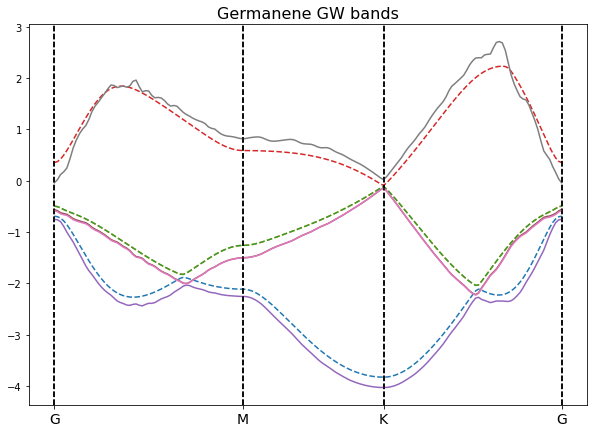

In [34]:
fig, ax = plt.subplots(figsize=(10, 7))
bands_dft.plot(plt,selection=[0,2,3,4],linestyle='--')
bands_gw.plot(plt,selection=[0,2,3,4],linestyle='-')
#plt.ylim(-1,1)
plt.title('Germanene GW bands',size=16)

Text(0.5, 1.0, 'Germanene GW bands close to K')

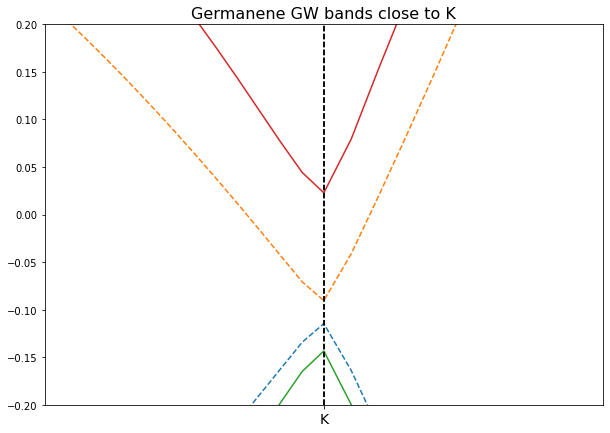

In [24]:
K_pos = bands_gw.get_high_sym_positions()[1][2]
dk = 0.08

fig, ax = plt.subplots(figsize=(10, 7))
bands_dft.plot(plt,selection=[2,4],linestyle='--')
bands_gw.plot(plt,selection=[2,4])
ax.set_xlim(K_pos-dk,K_pos+dk)
ax.set_ylim(-0.2,0.2)
plt.title('Germanene GW bands close to K',size=16)

In [25]:
Kp_ind = 120
gap_dft = 1e3*(bands_dft.bands[4][Kp_ind]-bands_dft.bands[3][Kp_ind])
gap_gw = 1e3*(bands_gw.bands[4][Kp_ind]-bands_gw.bands[3][Kp_ind])
gap_dft,gap_gw

(23.92724160000001, 166.05915679999998)

In [ ]:
for ind,k in enumerate(bands_dft.kpoints):
    print(ind,k)